In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.optimize import minimize
import scipy.fft as fft

ModuleNotFoundError: No module named 'pandas'

In [ ]:
root_dir = r"D:\A-deng\\hunter_data\\3.11\\right_180\\60"
# root_dir = r"D:\A-deng\hunter\demarcate_v2"
file_names = []

In [ ]:
def list_dirs(root_dir):
    '''
    深度优先遍历文件夹，将文件夹下所有文件的路径存入file_names
    '''
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_names.append(os.path.join(root, file))

In [ ]:
list_dirs(root_dir)
# file_names = file_names[0:1]

In [ ]:
def read_data(file_names):
    '''
    传入所有数据文件，返回数据，数据形式[x, y, increment, data_size]
    '''
    datalist = []
    for file_name in file_names:
        if file_name.endswith('.csv'):
            print(f"Processing file: {file_name}")
            df = pd.read_csv(file_name)
            y = df['Math'].drop(df.index[0]).astype(float).to_numpy()
            x_start = df["Start"].iloc[0].astype(float)
            x_increment = df["Increment"].iloc[0].astype(float)
            data_size = len(y)
            x_end = x_increment * data_size
            x = np.arange(x_start, x_end, x_increment)
            datalist.append([x, y, x_increment, data_size])
        
    return datalist

In [ ]:
data_list = read_data(file_names)

Processing file: D:\A-deng\\hunter_data\\3.11\\right_180\\60\1.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_39508\3781447833.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


Processing file: D:\A-deng\\hunter_data\\3.11\\right_180\\60\2.csv


C:\Users\dengyunqian\AppData\Local\Temp\ipykernel_39508\3781447833.py:9: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


In [ ]:
print(data_list)

[[array([0.0000000e+00, 8.0000000e-07, 1.6000000e-06, ..., 2.3999976e+00,
       2.3999984e+00, 2.3999992e+00]), array([0.214, 0.228, 0.219, ..., 0.216, 0.219, 0.221]), 8e-07, 3000000], [array([0.0000000e+00, 8.0000000e-07, 1.6000000e-06, ..., 2.3999976e+00,
       2.3999984e+00, 2.3999992e+00]), array([0.0649, 0.0672, 0.0696, ..., 0.0841, 0.0792, 0.0817]), 8e-07, 3000000]]


In [ ]:
# FFT
def do_fft(y, increment, data_size):
    '''
    对y进行FFT变换，返回FFT结果和频率
    '''
    fft_result = fft.fft(y)
    fft_freq = fft.fftfreq(data_size, increment)
    return fft_result, fft_freq

In [ ]:
fft_results = []
fft_freqs = []
params_b = []
fft_results_peaks=[]
phases = []

for data in data_list:
    fft_result, fft_freq = do_fft(data[1], data[2], data[3])
    fft_results.append(fft_result)
    fft_freqs.append(fft_freq)

    # 寻找FFT结果中的峰值
    peaks, _ = find_peaks(np.abs(fft_result), height=data[3]*0.01)  # height是选中阈值

    # 获取峰值的频率和振幅
    peak_frequencies = fft_freq[peaks]
    peak_amplitudes = np.abs(fft_result[peaks])
    fft_results_peaks.append(fft_result[peaks])
    print(fft_result[peaks])
    angles = np.angle(fft_result[peaks])

    b = 0
    # 打印峰值信息
    for i, frequency in enumerate(peak_frequencies):
        if frequency > 0:
            print(f"峰值 {i + 1}: 频率 = {frequency} Hz, 振幅 = {peak_amplitudes[i]}, 相位 = {angles[i]}")

            if 2 * np.pi * frequency > b:
                b = 2 * np.pi * frequency
                phase = angles[i]
    
    params_b.append(b)
    phases.append(phase)

[302902.66202588-75473.92235431j 302902.66202588+75473.92235431j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 312163.9563080718, 相位 = -0.2441962961975358
[111647.1509523-25484.17414347j 111647.1509523+25484.17414347j]
峰值 1: 频率 = 5.0 Hz, 振幅 = 114518.68601909607, 相位 = -0.22441173865162878


In [ ]:
def ifft_filter(fft_result, fft_freq, desired_frequency, bandwidth):
    '''
    逆FFT滤波，传入参数为数据，采样频率(即1/increment)，数据长度，保留的频率，频率带宽，返回滤波后的数据
    '''

    # 应用滤波器
    fft_result_filtered = np.copy(fft_result)
    fft_result_filtered[(fft_freq > desired_frequency + bandwidth/2) | (fft_freq < desired_frequency - bandwidth/2)] = 0

    # 执行逆FFT
    filtered_signal = fft.ifft(fft_result_filtered)

    # 取实部，因为IFFT的结果可能包含复数
    return filtered_signal.real

In [ ]:
def plot_ifft_figure(x, y, filtered_signal):
    '''
    绘制原始和滤波后的信号
    '''
    plt.figure(figsize=(10, 6))
    x_interval = 0.1
    plt.plot(x, y, label='source')
    plt.plot(x, filtered_signal, label='filtered red', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(np.arange(min(x), max(x)+x_interval, x_interval))
    plt.show()

 \1.csv : 



d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


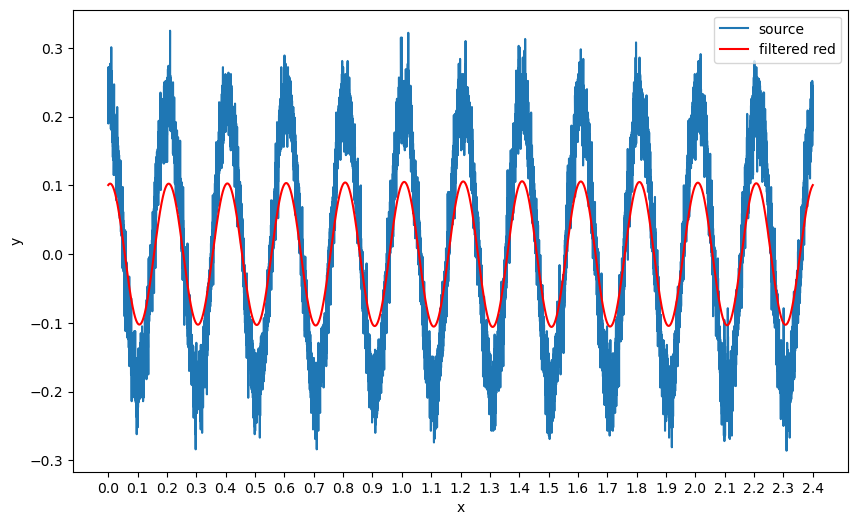

 \2.csv : 



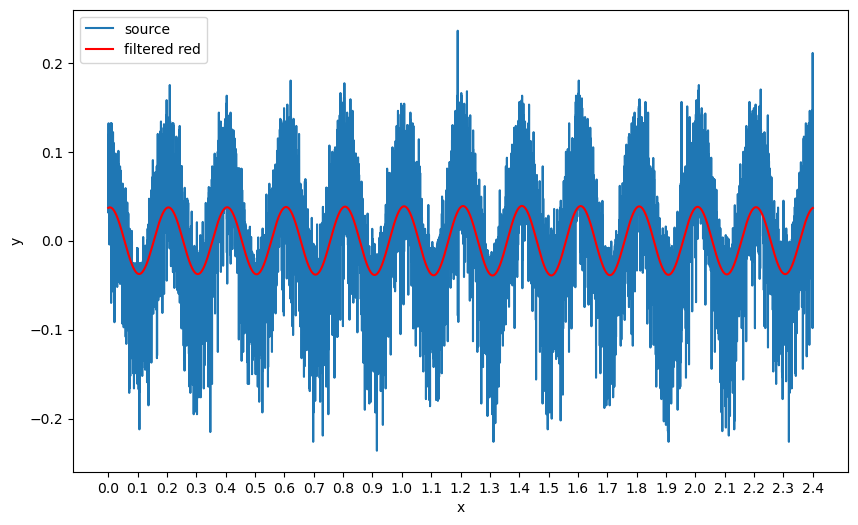

In [ ]:
filtered_signals = []

for i in range(len(data_list)):
    filtered_signal = ifft_filter(fft_results[i], fft_freqs[i], params_b[i] / 2 / np.pi, 1)
    filtered_signals.append(filtered_signal)
    print(f" {file_names[i][len(root_dir):]} : \n")
    plot_ifft_figure(data_list[i][0], data_list[i][1], filtered_signal) 

In [ ]:
def plot_curve(x, y, b, popt):
    # 模型函数f(x) = acos(bx+c)
    def func_model(x, a, c):
        return a * np.cos(b * x + c)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='source')
    plt.plot(x, func_model(x, *popt), label='fitting', color='red')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show() 

In [ ]:
# 计算滤波后逆FFT得到的a
ifft_fit_popts = []
for i in range(len(filtered_signals)):
    max_a = 0
    max_a_index = 0
    for j in range(len(filtered_signals[i])):
        temp_y = filtered_signals[i][j]
        if temp_y > max_a:
            max_a = temp_y
            max_a_index = j
    
    max_x = data_list[i][0][max_a_index]
    c = - max_x * params_b[i]     # 取最大值时 bx+c = 0

    ifft_fit_popts.append([max_a, c])

# print(params_b)

In [ ]:
# 保存拟合结果
with open('fit_test_40_left_90.txt', 'w+', encoding="utf-8") as f:
    for i in range(len(filtered_signals)):
         f.write(f" {file_names[i][len(root_dir):]} : \n")
         f.write(f" fft + ifft fit : \n s = {ifft_fit_popts[i][0]} *cos( {params_b[i]} *x + {phases[i]} )\n\n\n")
        #  f.write(f"f = {ifft_fit_popts[i][0]} *cos( {params_b[i]} *x + {phases[i]} )\n")
        # f.write(f" fft + opt fit : \n f = {popts[i][0]} *sin( {params_b[i]} *x + {popts[i][1]} )\n\n")

In [ ]:
def calculate_F(A, E1_matrix):
    F = np.dot(A, E1_matrix)
    return F


In [ ]:
F=[]
E1_matrix=[]
for i in range(len(filtered_signals)):
    E1_matrix.append(ifft_fit_popts[i][0])
print(E1_matrix)

[0.10599005688945255, 0.03907543556935793]


In [ ]:
A=[[-137.22019013,513.56636451],[257.05723773,-649.12064563]]
F=calculate_F(A,E1_matrix)
print(root_dir)
print("F=",F)

D:\A-deng\\hunter_data\\3.11\\right_180\\60
F= [34.61180515  1.88083929]


In [ ]:
def calculate_M(F, omega, R):
    M = F / (omega**2 * R)
    return M

In [ ]:
M=[]
T = 0.2
omega = 2 * np.pi / T
R=0.1778
M=calculate_M(F,omega,R)
print(root_dir)
print("M=",M)

D:\A-deng\\hunter_data\\3.11\\right_180\\60
M= [0.19723898 0.01071816]
